In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from analyzer.metric import MetricCalculator
from data import Reader, Saver
from plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from encoder import Encoder
from preparation import DataPreparation, Normalizer
from analyzer.model import KNNHandMade

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## Исходные данные

In [124]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv('https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_KNN_IncomeMoney.csv')
df = df_original.copy().reset_index(drop=True)
df = Reader.replace_symbol_in_data(df, '?')
df.head(10)

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
0,47,State-gov,80282,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States,<=50K
1,20,Private,112854,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,32,United-States,<=50K
2,44,Self-emp-inc,49249,Some-college,10,Divorced,Other-service,Unmarried,White,Male,0,0,80,United-States,<=50K
3,49,Private,182862,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,7688,0,40,United-States,>50K
4,37,Private,175759,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,>50K
5,50,Self-emp-inc,101094,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States,<=50K
6,52,State-gov,71344,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
7,58,Self-emp-not-inc,33309,HS-grad,9,Widowed,Farming-fishing,Not-in-family,White,Male,0,0,80,United-States,<=50K
8,35,Self-emp-not-inc,157473,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
9,55,Private,177380,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,29,United-States,<=50K


fnlwgt (final weight) – примерная оценка количества людей, которое представляет каждая строка данных

educational-num – длительность обучения

capital gain - это экономическая концепция, определяемая как прибыль, полученная от продажи актива, стоимость которого увеличилась за период владения.

capital loss — это убыток, который возникает, когда стоимость капитальных активов, таких как инвестиции или недвижимость, снижается.

## Постановка задачи
1. Определить какие признаки более всего влияют на таргет, 
2. построить модель наивного Байеса когда все колонки переведны в вид категорий, 
3. построить модель логистической регрессии с L1 регуляризацией, чтобы выявить какие признаки "мусорные", 
4. после лекции в понедельник построить дерево решений и модель svm.

## оптимизация данных

In [125]:
# посмотрим на пропуски в данных
df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational_num    0
marital_status     0
occupation         0
relationship       0
race               0
gender             0
capital_gain       0
capital_loss       0
hours_per_week     0
native_country     0
income             0
dtype: int64

In [126]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational_num  48842 non-null  int64 
 5   marital_status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital_gain     48842 non-null  int64 
 11  capital_loss     48842 non-null  int64 
 12  hours_per_week   48842 non-null  int64 
 13  native_country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [127]:
df.describe()

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [128]:
# Оптимизируем память
df['age'] = df['age'].astype('uint8')
df['fnlwgt'] = df['fnlwgt'].astype('int32')
df['educational_num'] = df['educational_num'].astype('uint8')
df['capital_gain'] = df['capital_gain'].astype('uint32')
df['capital_loss'] = df['capital_loss'].astype('uint16')
df['hours_per_week'] = df['hours_per_week'].astype('uint8')

# Убеждаемся в изменениях
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  uint8 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int32 
 3   education        48842 non-null  object
 4   educational_num  48842 non-null  uint8 
 5   marital_status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital_gain     48842 non-null  uint32
 11  capital_loss     48842 non-null  uint16
 12  hours_per_week   48842 non-null  uint8 
 13  native_country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int32(1), object(9), uint16(1), uint32(1), uint8(3)
memory usage: 4.0+ MB


In [129]:
df.describe()

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


## визуальный анализ

In [130]:
# Посмотрим описательную статистику непрерывных величин
df.describe()

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


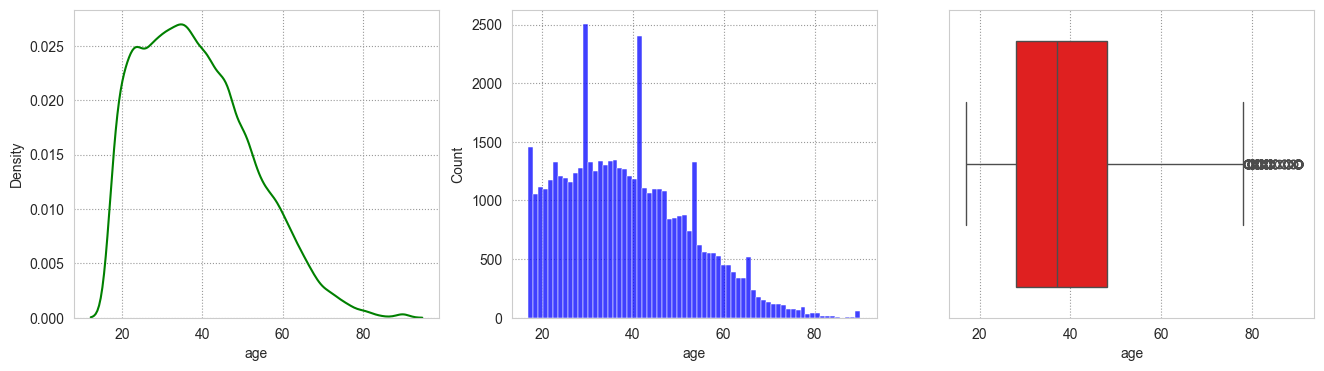

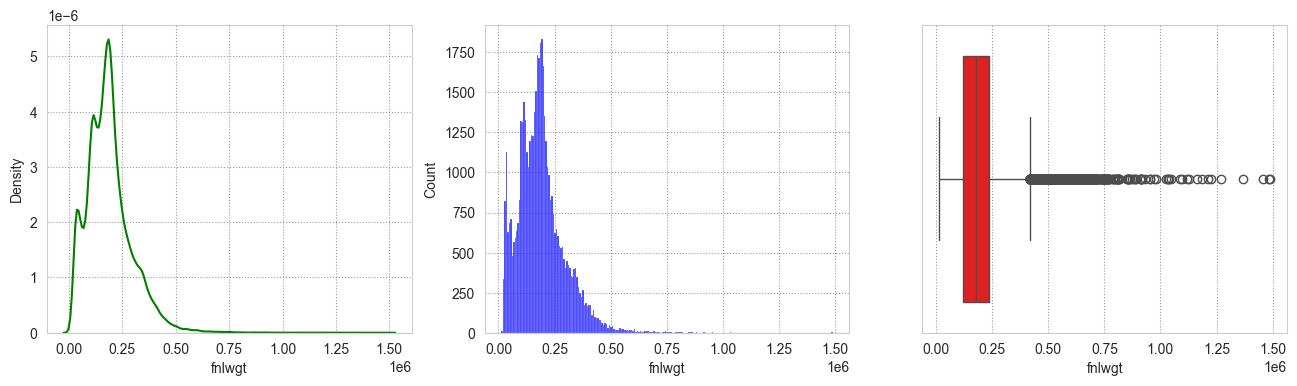

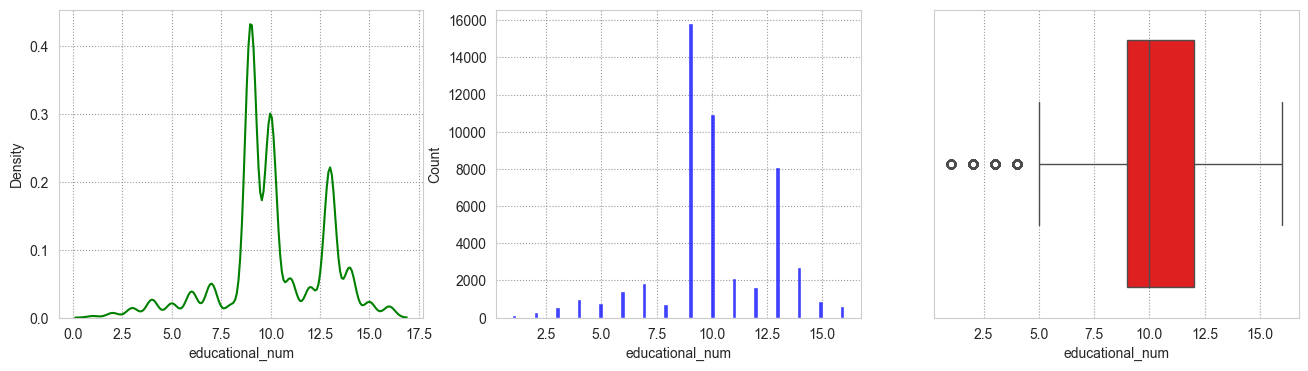

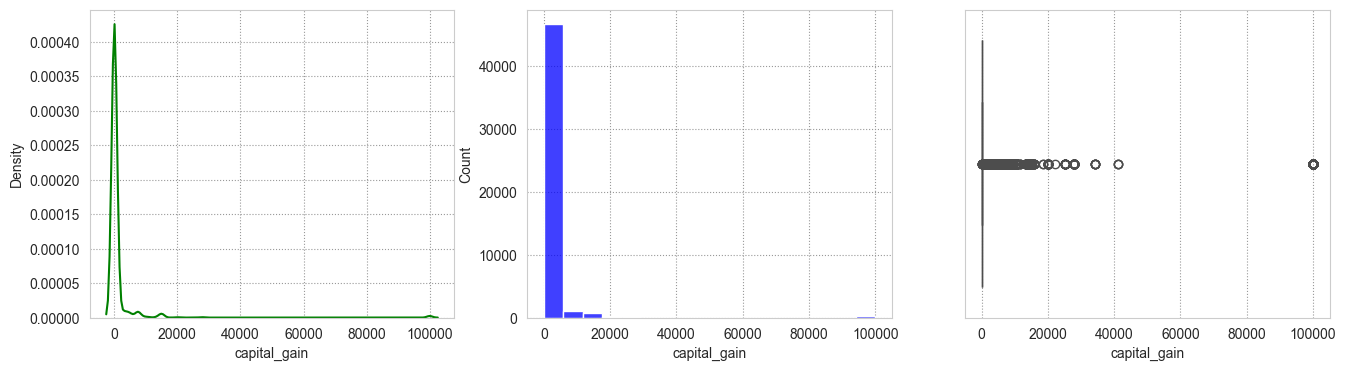

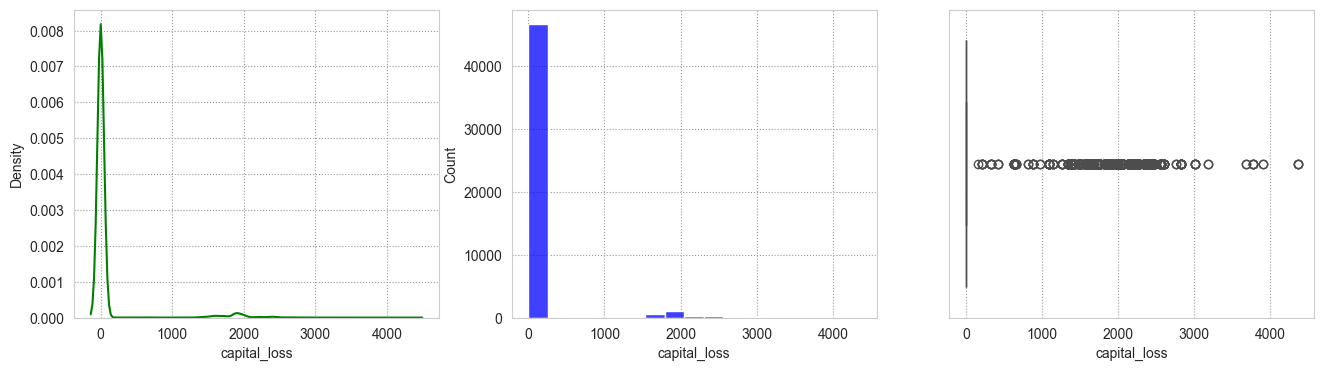

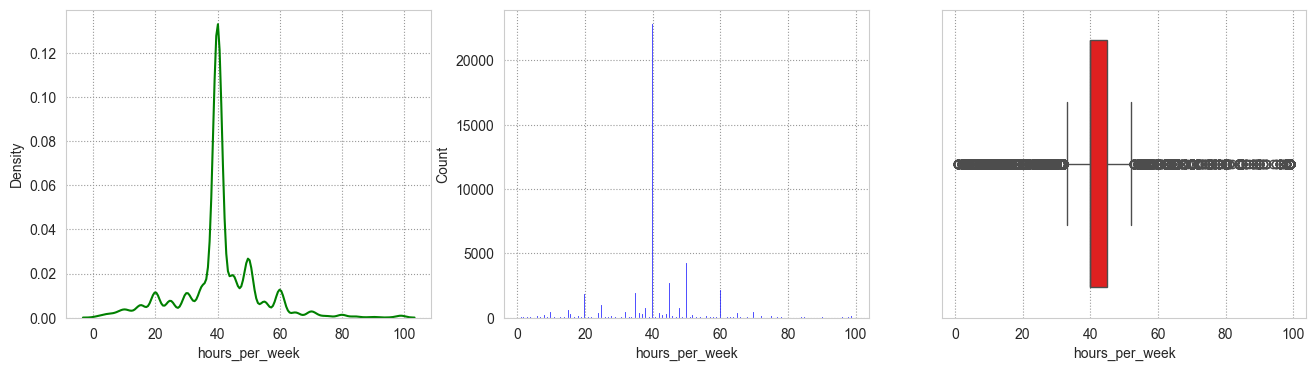

In [131]:
# Посмотрим на распределение непрерывных величин
Drawer.plot_numeric_seaborn(df)
# Drawer.plot_numeric_plotly(df)

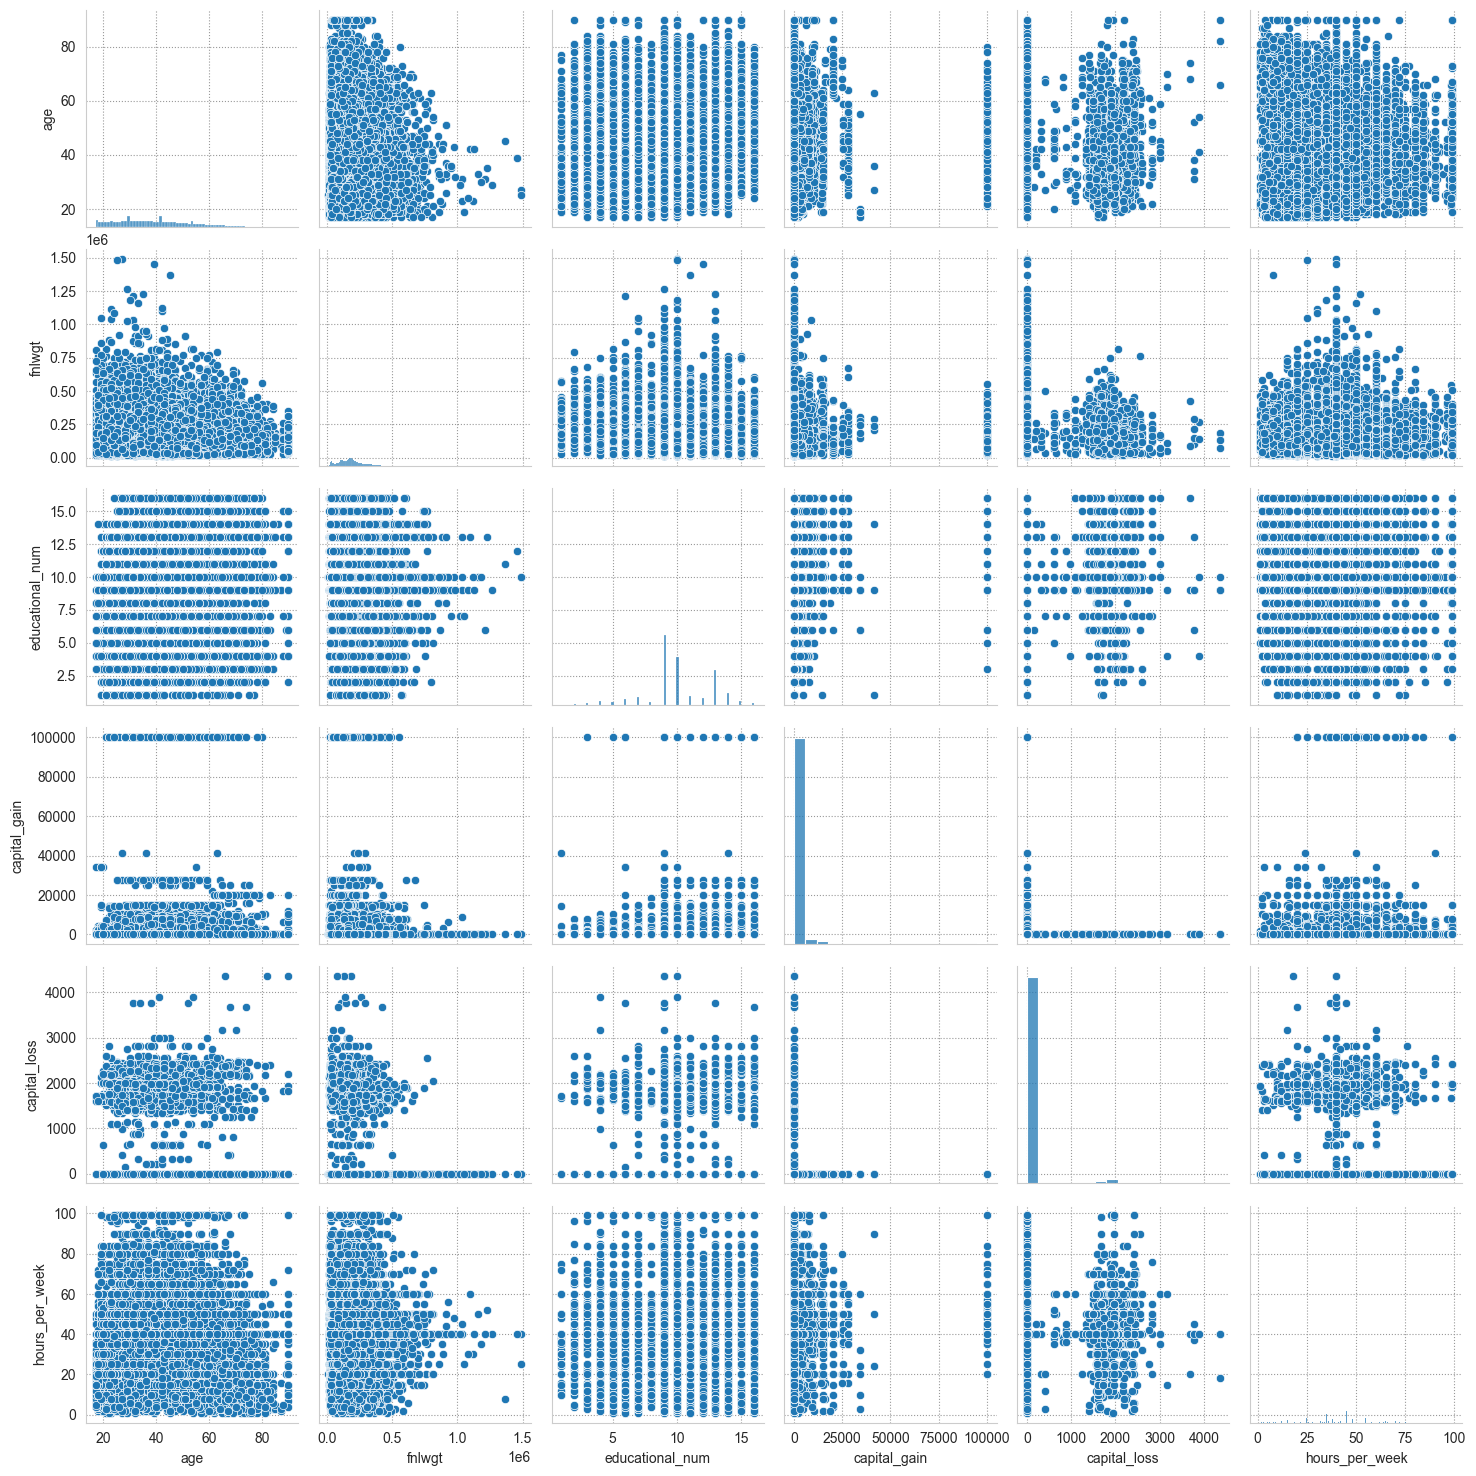

In [132]:
# Исследуем графически зависимость признаков на целевую переменную для обычной недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

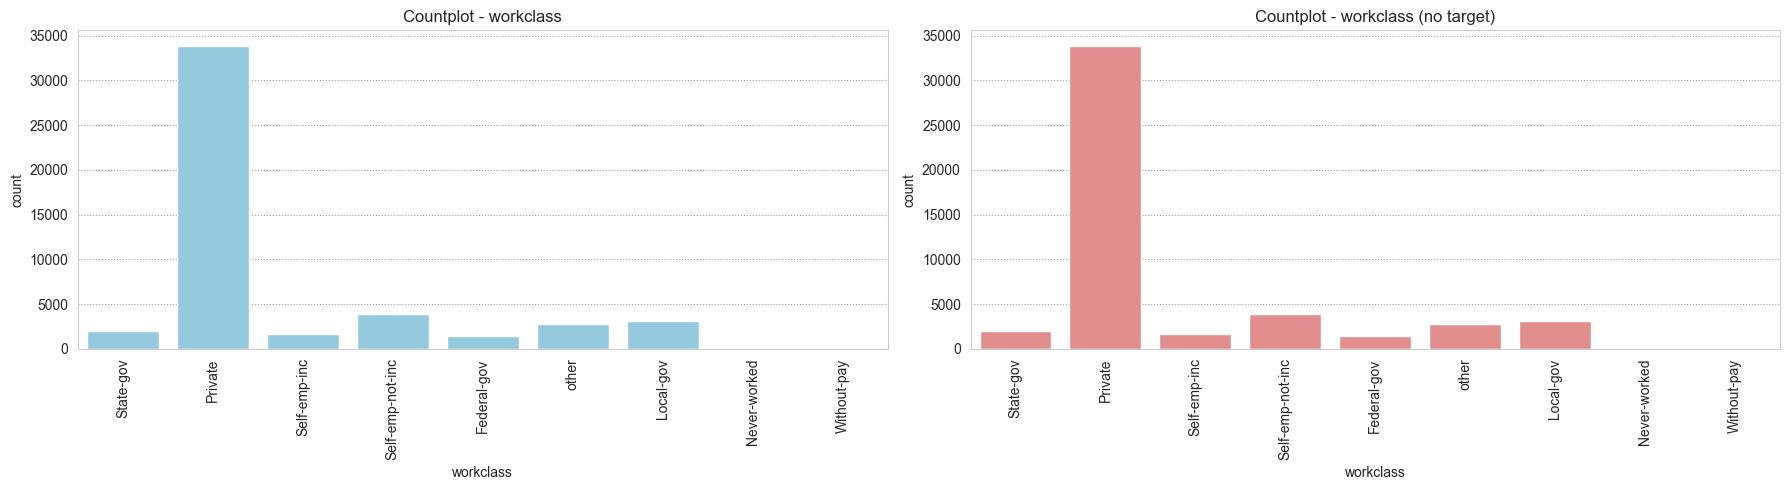

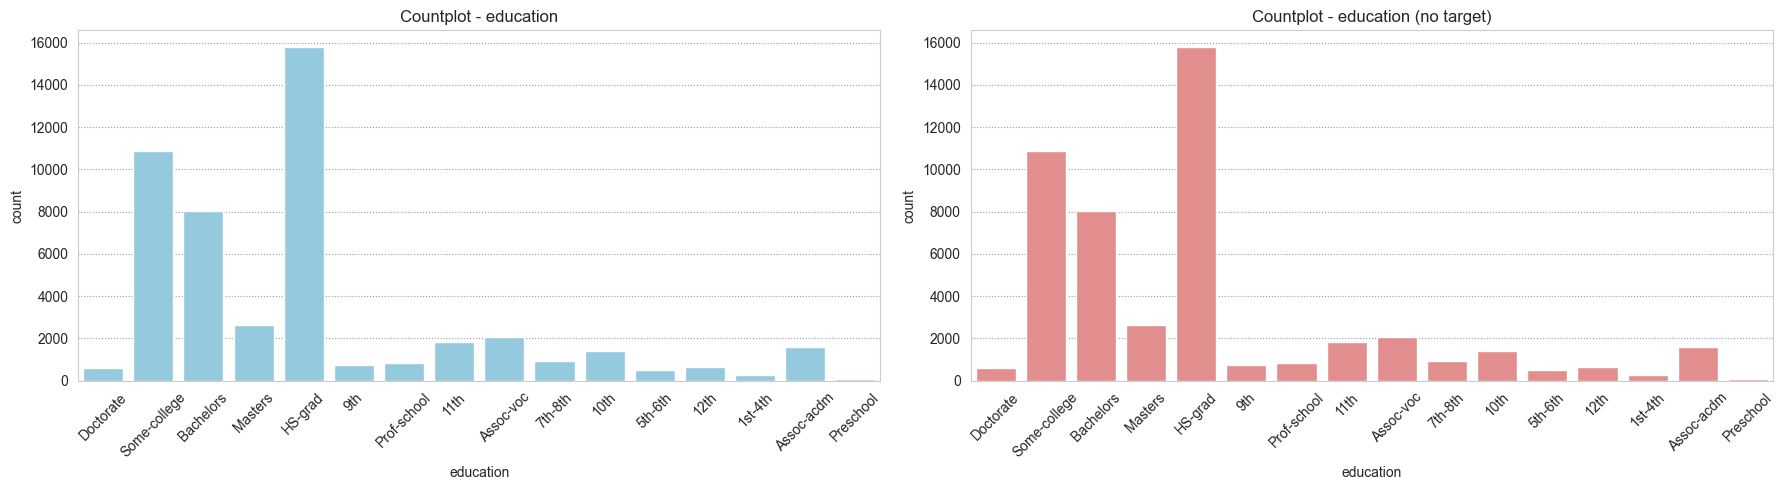

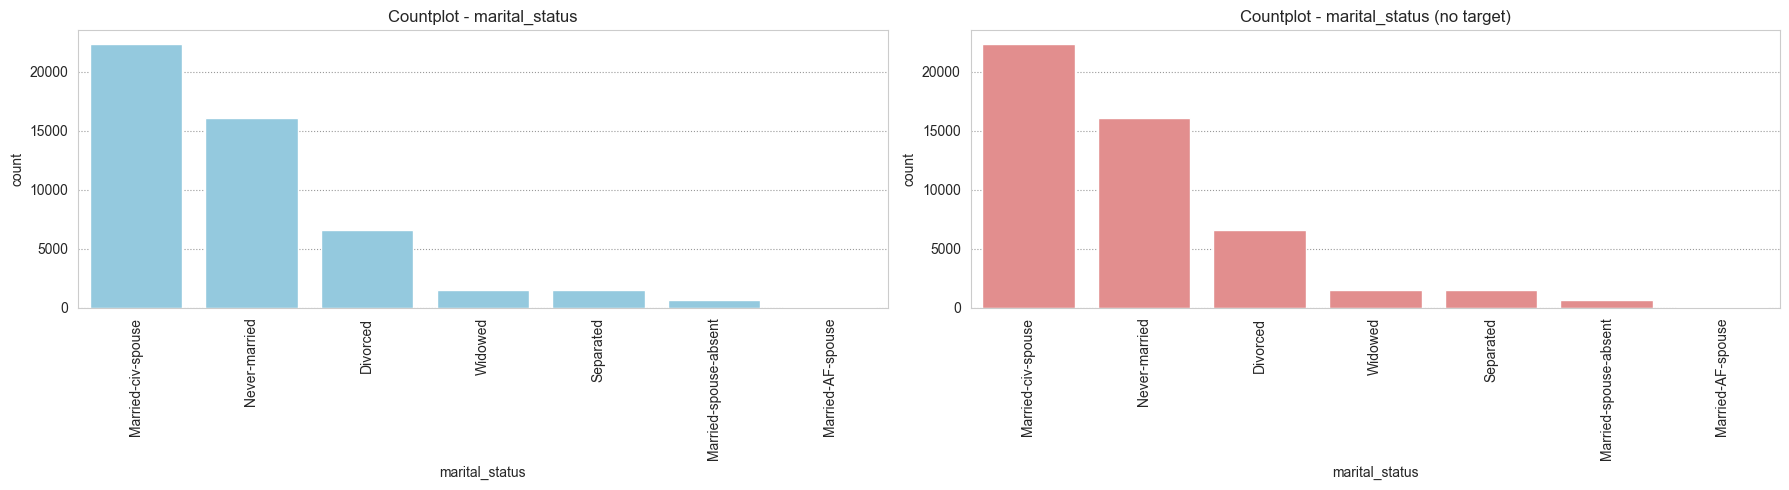

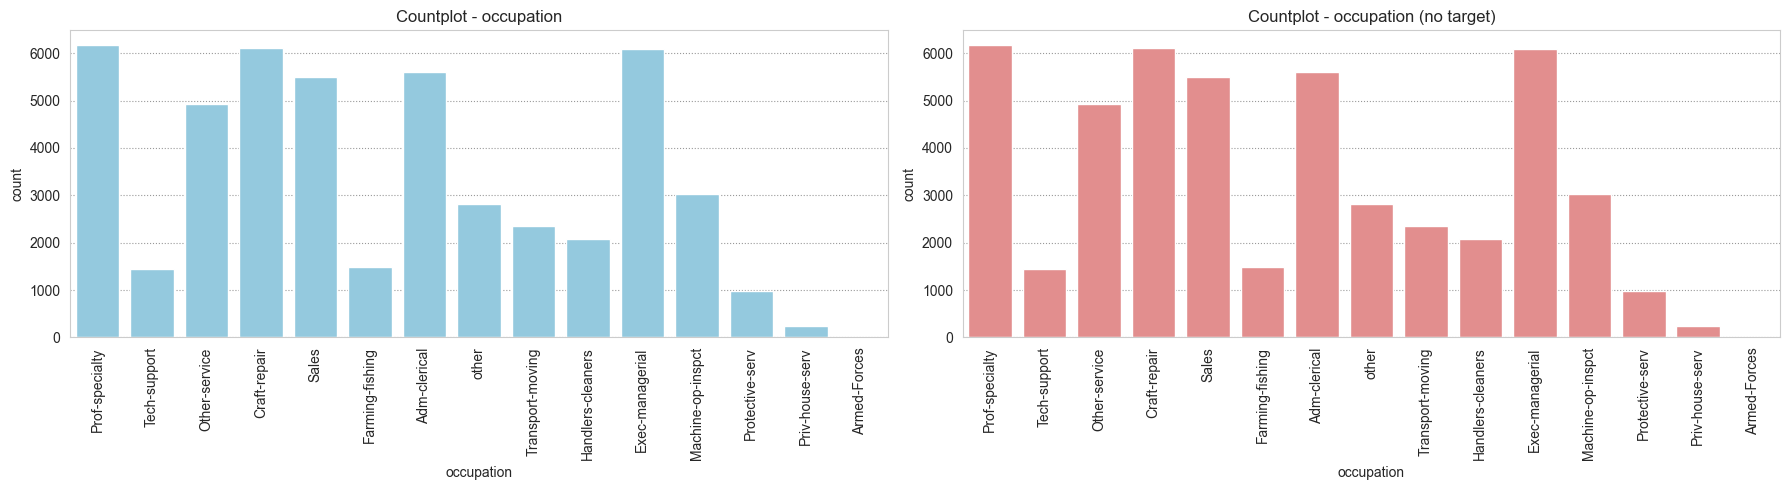

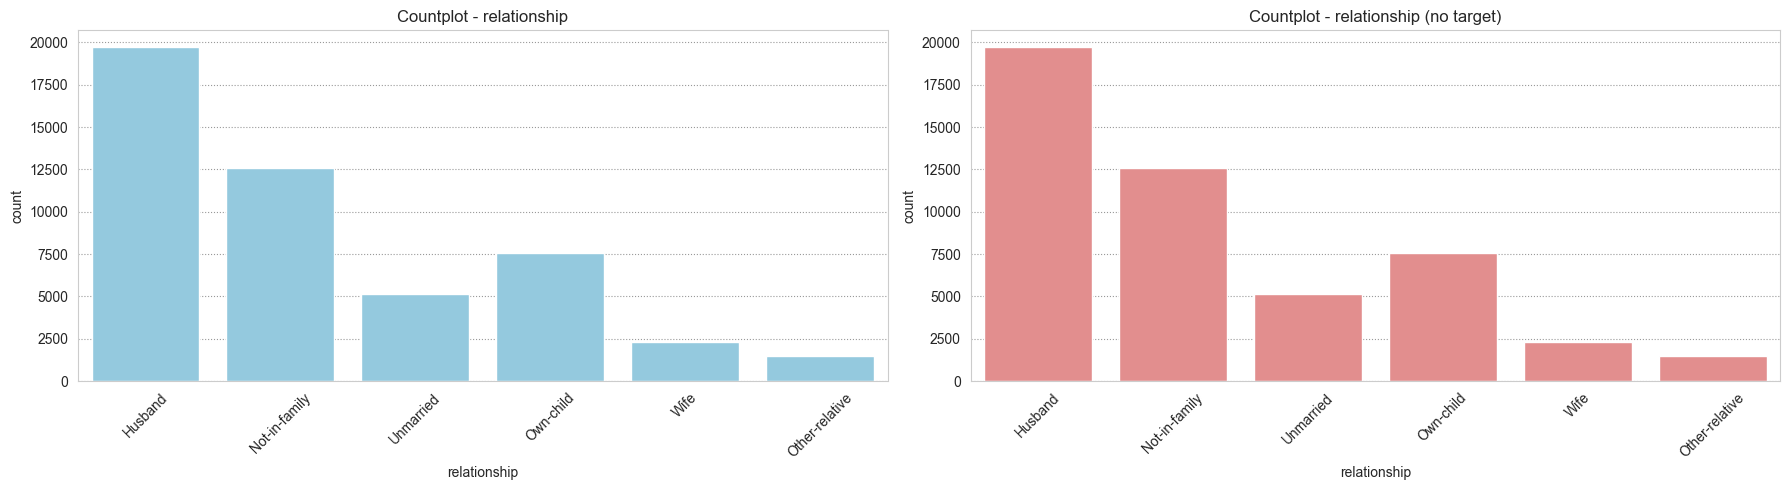

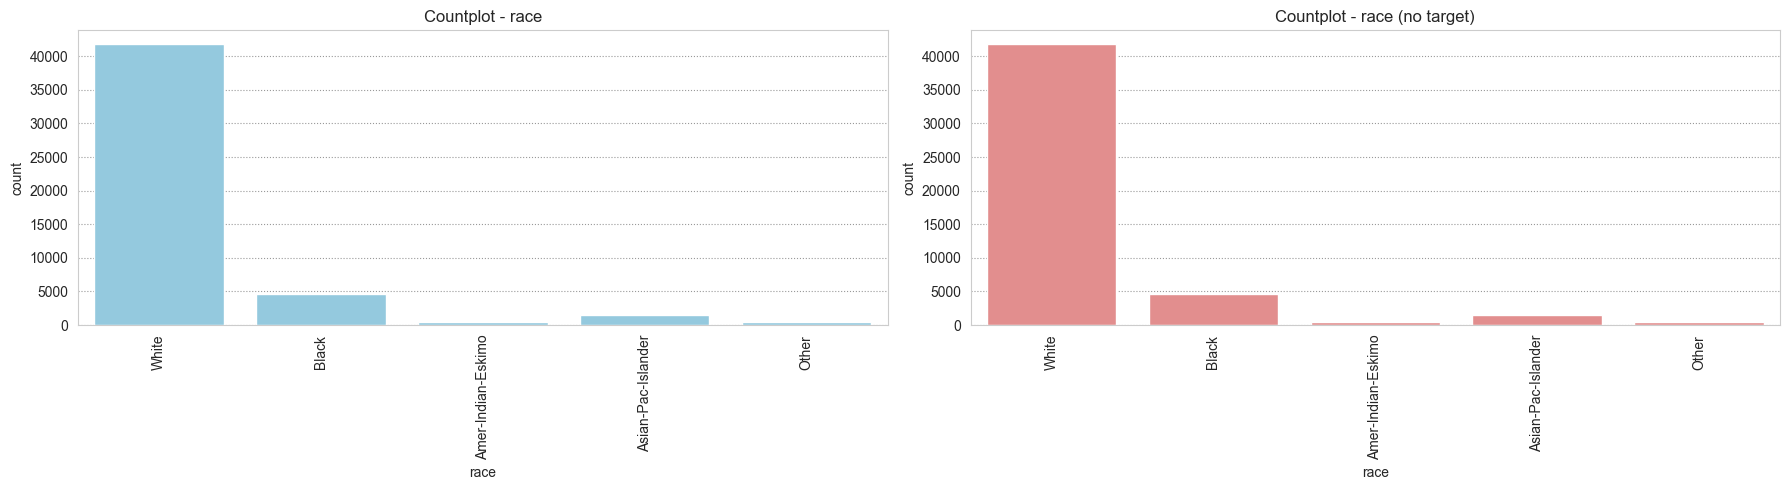

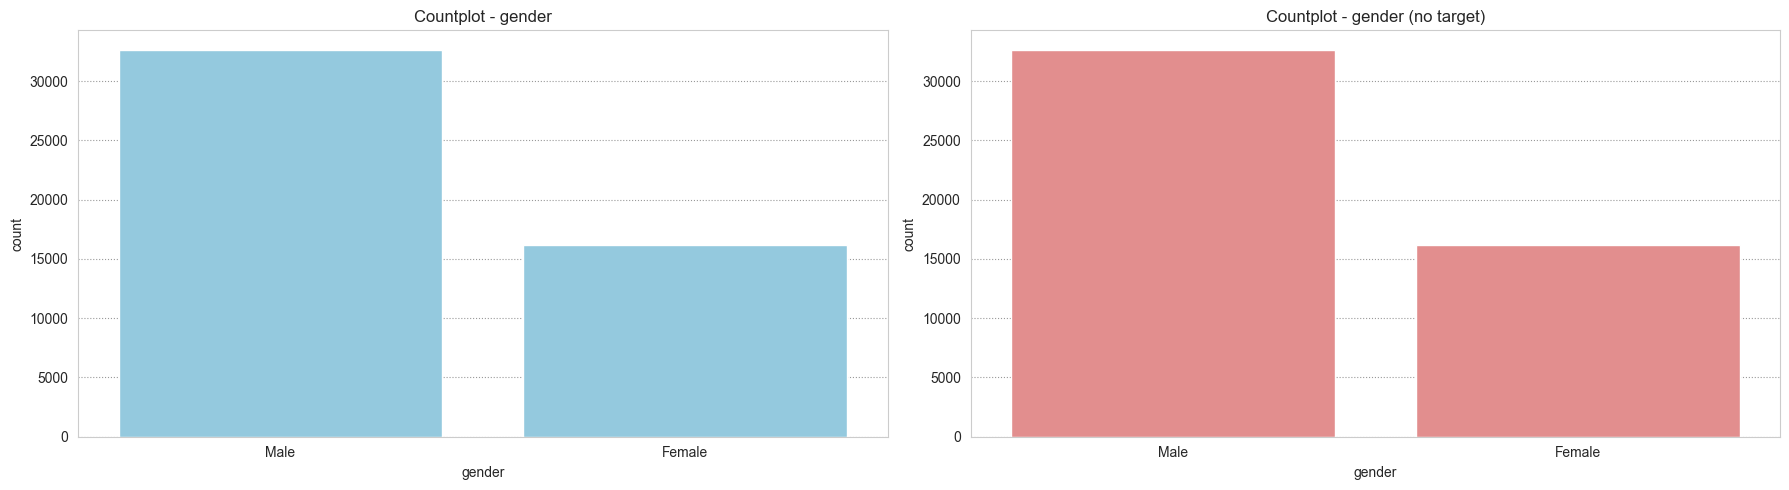

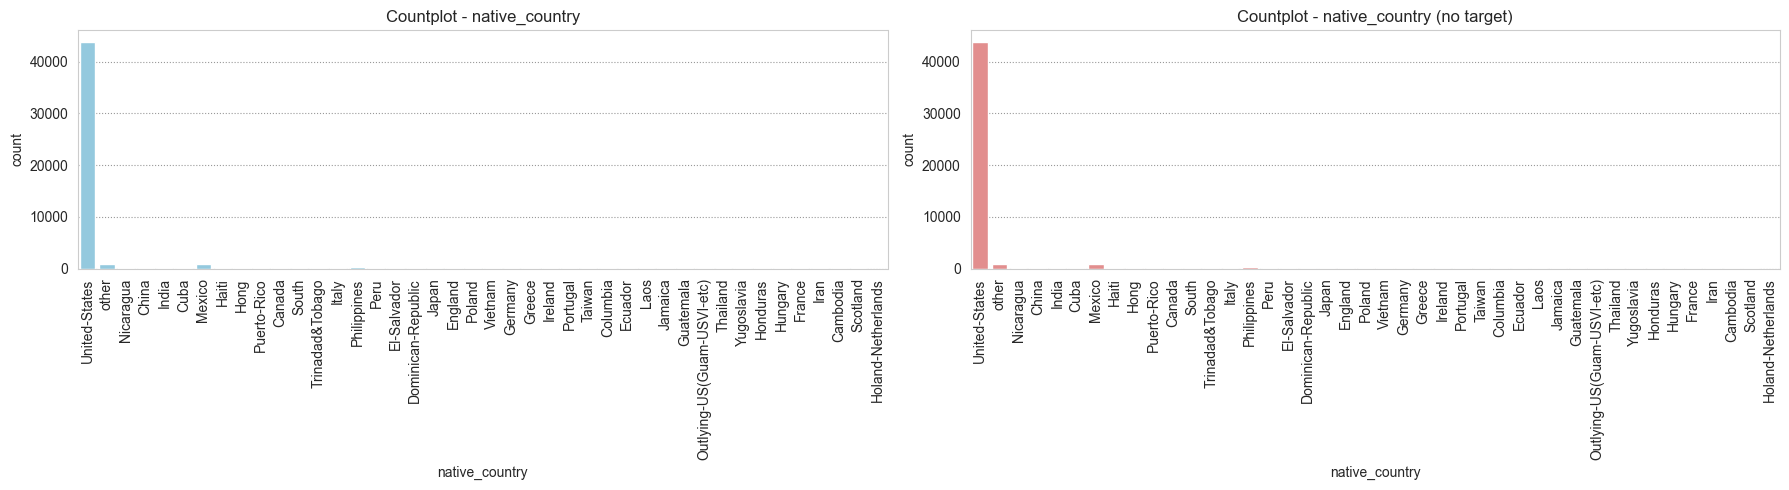

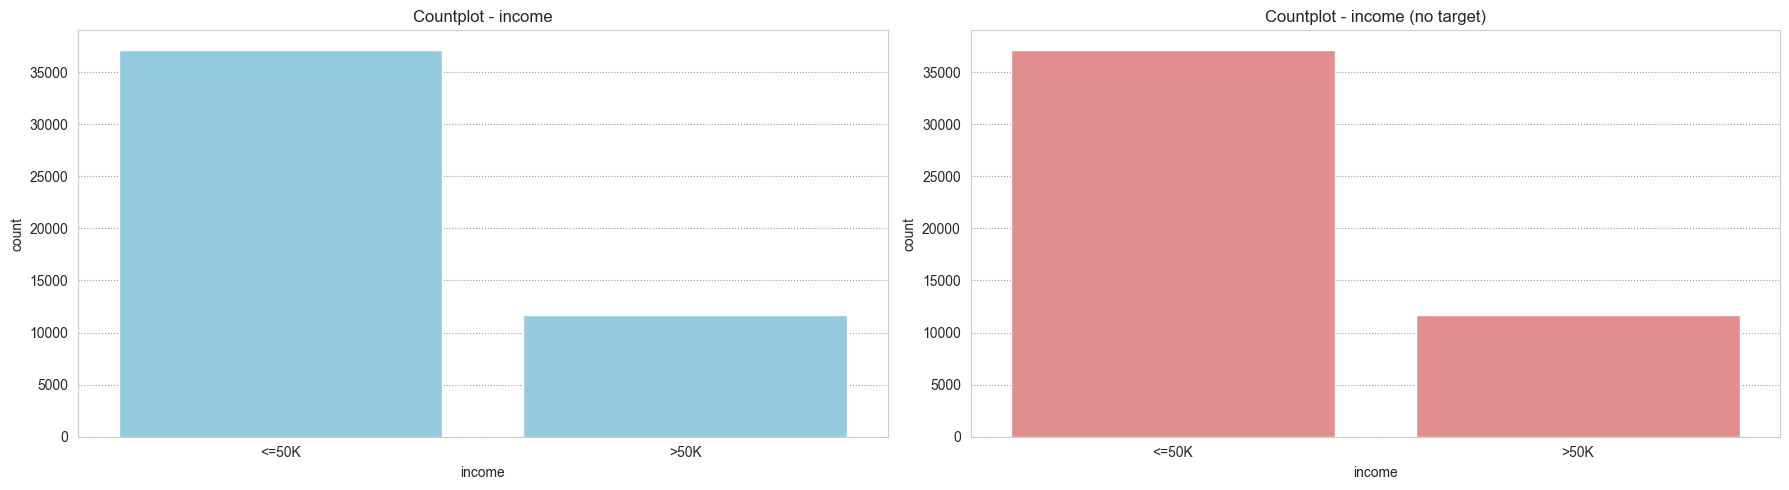

In [133]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)
# Drawer.plot_categorical_plotly(df)

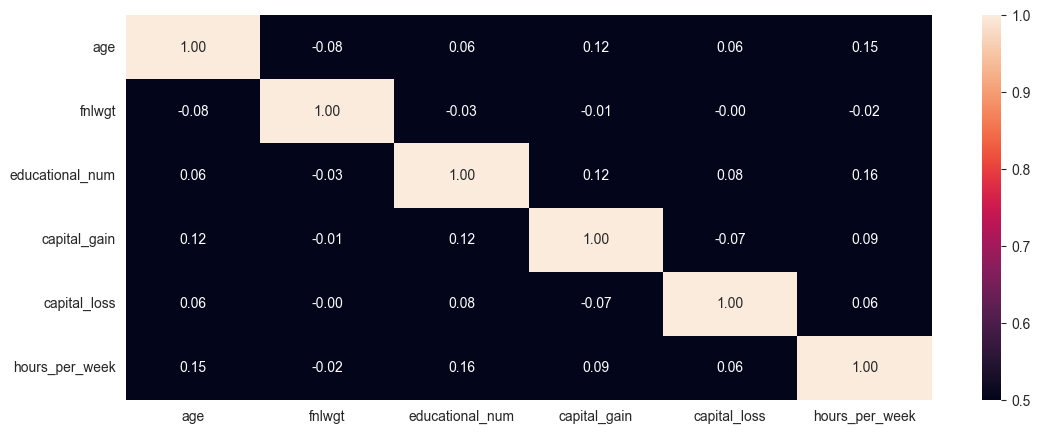

In [134]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

## стат.обработка

In [135]:
df.select_dtypes(include='number').columns


Index(['age', 'fnlwgt', 'educational_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')

In [136]:
StatCriteria().mannwhitneyu(df, 'income', 'age')
StatCriteria().mannwhitneyu(df, 'income', 'fnlwgt')
StatCriteria().mannwhitneyu(df, 'income', 'educational_num')
StatCriteria().mannwhitneyu(df, 'income', 'capital_gain')
StatCriteria().mannwhitneyu(df, 'income', 'capital_loss')
StatCriteria().mannwhitneyu(df, 'income', 'hours_per_week')

Mann-Whitney U test
U_statistic = 137973415.500
Распределения двух выборок не равны (p-value = 0.000).
Mann-Whitney U test
U_statistic = 218858803.500
Распределения двух выборок равны (p-value = 0.190).
Mann-Whitney U test
U_statistic = 123219773.500
Распределения двух выборок не равны (p-value = 0.000).
Mann-Whitney U test
U_statistic = 178157870.500
Распределения двух выборок не равны (p-value = 0.000).
Mann-Whitney U test
U_statistic = 202262066.000
Распределения двух выборок не равны (p-value = 0.000).
Mann-Whitney U test
U_statistic = 142488722.000
Распределения двух выборок не равны (p-value = 0.000).


In [137]:
df.select_dtypes(include='object').columns


Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'gender', 'native_country', 'income'],
      dtype='object')

In [138]:
StatCriteria().chi2_contingency(df, 'workclass', 'income')
StatCriteria().chi2_contingency(df, 'education', 'income')
StatCriteria().chi2_contingency(df, 'marital_status', 'income')
StatCriteria().chi2_contingency(df, 'occupation', 'income')
StatCriteria().chi2_contingency(df, 'relationship', 'income')
StatCriteria().chi2_contingency(df, 'race', 'income')
StatCriteria().chi2_contingency(df, 'income', 'gender')
StatCriteria().chi2_contingency(df, 'native_country', 'income')

Chi-square test
chisq_statistic = 1610.752, dof = 8.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 6537.973, dof = 15.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 9816.015, dof = 6.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 5983.164, dof = 14.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 10088.722, dof = 5.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 487.026, dof = 4.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 2248.848, dof = 1.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 452.229, dof = 41.000
Две переменные зависимы (p-value = 0.000).


## подготовка данных для обучения

In [139]:
# кодируем данные общего датасета
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['native_country'] = df['native_country'].apply(lambda x: 1 if 'United-States' else 0)
df['race'] = df['race'].apply(lambda x: 1 if 'white' else 0)

In [140]:
df.groupby(['education', 'educational_num'])['educational_num'].mean()

education     educational_num
10th          6                   6.0
11th          7                   7.0
12th          8                   8.0
1st-4th       2                   2.0
5th-6th       3                   3.0
7th-8th       4                   4.0
9th           5                   5.0
Assoc-acdm    12                 12.0
Assoc-voc     11                 11.0
Bachelors     13                 13.0
Doctorate     16                 16.0
HS-grad       9                   9.0
Masters       14                 14.0
Preschool     1                   1.0
Prof-school   15                 15.0
Some-college  10                 10.0
Name: educational_num, dtype: float64

In [141]:
# разделяем данные
# exclude_features = ['income', 'education']
exclude_features = ['income', 'education','fnlwgt']
# exclude_features = ['income', 'education', 'age','fnlwgt','race','native_country']  ## добавлено по результатам L1 регуляризации
target = ['income']
X_train, X_test, y_train, y_test = DataPreparation().prepare_data(df, exclude_features, target)

In [142]:
# кодируем данные в зависимости от таргета
columns_for_encoding = ['workclass', 'marital_status', 'occupation', 'relationship']

for column in columns_for_encoding:
  X_train[column], encoder = Encoder.targetEncoder(X_train[column], y_train)
  X_test[column] = encoder.transform(X_test[column])


In [143]:
X_train.head()

,age,workclass,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country
27859,27,0.219667,8,0.046448,0.228745,0.014454,1,1,0,0,40,1
5654,52,0.219667,13,0.447110,0.296875,0.449416,1,1,7688,0,38,1
3779,74,0.267434,10,0.066667,0.272727,0.103629,1,1,0,0,16,1
10522,52,0.267434,10,0.447110,0.296875,0.449416,1,1,0,0,45,1
22461,48,0.219667,10,0.447110,0.478929,0.449416,1,1,0,0,40,1


In [144]:
X_train, X_test, _, _ = Normalizer.standard_scaler(X_train, X_test, y_train, y_test)

## проводим обучение

In [145]:
# Наивный байесовский классификатор
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns)
MetricCalculator.show_classification_metrics(y_test, y_pred)

Accuracy: 0.84
Precision: 0.83
Recall: 0.84
F1-score: 0.83


C:\Users\Tikhon\Documents\PycharmProjects\PDA120_practice2\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [146]:
# Логистическая регрессия с L1-регуляризацией
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=0.1)
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns)

MetricCalculator.show_classification_metrics(y_test, y_pred)
print('__________')
print(*[f"{feature}: {coef:.2f}" for feature, coef in zip(X_train.columns, model.coef_.flatten())], sep='\n')

Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1-score: 0.85
__________
age: 0.32
workclass: 0.04
educational_num: 0.68
marital_status: 0.61
occupation: 0.46
relationship: 0.65
race: 0.00
gender: 0.04
capital_gain: 2.27
capital_loss: 0.27
hours_per_week: 0.32
native_country: 0.00


C:\Users\Tikhon\Documents\PycharmProjects\PDA120_practice2\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


признаки, которые можно исключить:
age,
fnlwgt,
capital_gain,
capital_loss,
hours_per_week

In [147]:
#SVC по умолчанию имеет следующие ядра: rbf, linear, poly, sigmoid
model = svm.SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns)
MetricCalculator.show_classification_metrics(y_test, y_pred)

C:\Users\Tikhon\Documents\PycharmProjects\PDA120_practice2\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.86
Precision: 0.85
Recall: 0.86
F1-score: 0.85


              precision    recall  f1-score   support

           0       0.85      0.95      0.90      9366
           1       0.74      0.45      0.56      2845

    accuracy                           0.84     12211
   macro avg       0.80      0.70      0.73     12211
weighted avg       0.83      0.84      0.82     12211

Accuracy: 0.84
Precision: 0.83
Recall: 0.84
F1-score: 0.82


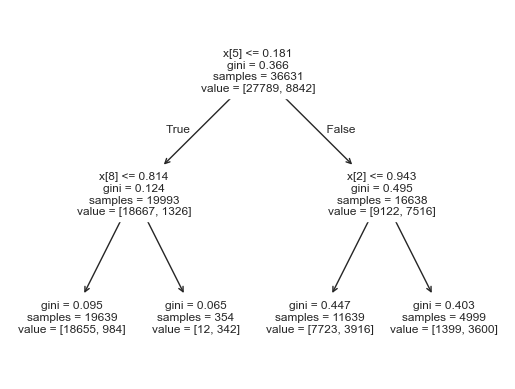

In [148]:
#Создать классификатор на основе дерева решений
model = tree.DecisionTreeClassifier(max_depth=2, criterion='gini')
model.fit(X_train,y_train)
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns)
tree.plot_tree(model)

print(classification_report(y_test,y_pred))
MetricCalculator.show_classification_metrics(y_test, y_pred)

In [149]:
# KNN модель из sklearn
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns)

MetricCalculator.show_classification_metrics(y_test, y_pred)

C:\Users\Tikhon\Documents\PycharmProjects\PDA120_practice2\venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.84
Precision: 0.84
Recall: 0.84
F1-score: 0.84


In [150]:
# самописная KNN модель
model = KNNHandMade(5, 'euclidean')
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns)

MetricCalculator.show_classification_metrics(y_test, y_pred)

Accuracy: 0.84
Precision: 0.84
Recall: 0.84
F1-score: 0.84
